<a href="https://colab.research.google.com/github/eysaritas/Diabetes-Prediction-System-/blob/main/SizeCoinSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Referans Para (En Büyük) Yarıçapı: 138.90 px -> 1 TL kabul edildi.
Para Yarıçapı: 138.9 px (Oran: 1.00) -> 1 TL
Para Yarıçapı: 136.1 px (Oran: 0.98) -> 1 TL
Para Yarıçapı: 108.9 px (Oran: 0.78) -> 25 Kr
Para Yarıçapı: 108.0 px (Oran: 0.78) -> 25 Kr


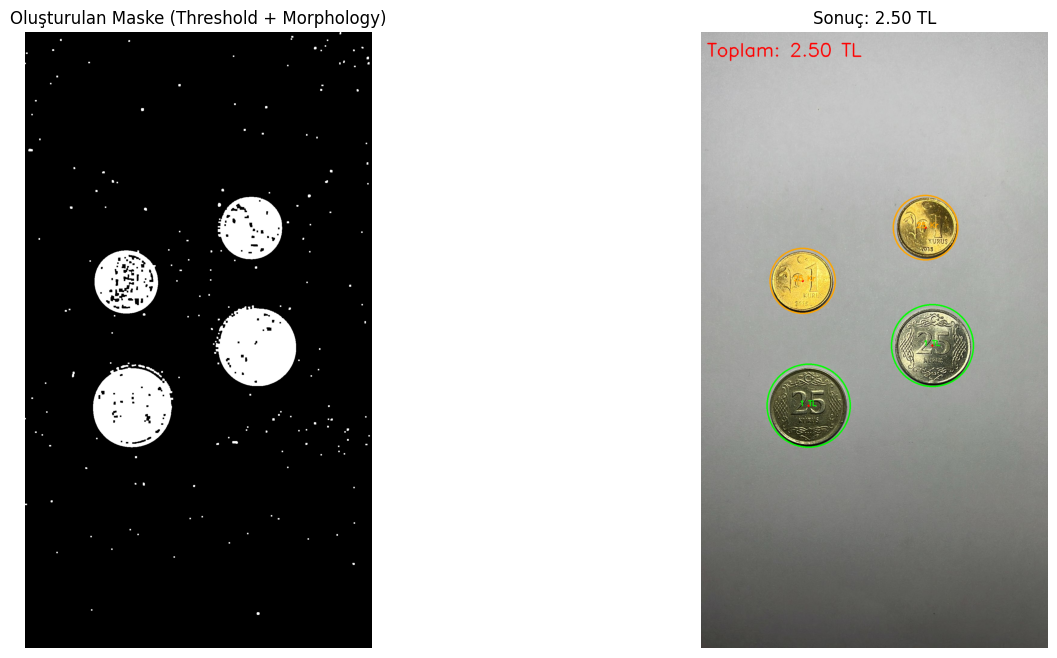

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def akilli_para_say(image_path):
    # 1. Görüntü Yükleme
    img = cv2.imread("ornek4.jpeg")
    if img is None:
        print("Hata: Görüntü yüklenemedi.")
        return

    output = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Ön İşleme: Gürültü Azaltma
    # Biraz daha güçlü bir blur kullanıyoruz ki detaylar kaybolsun, sadece "yuvarlaklık" kalsın.
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    # 3. Adaptive Thresholding (Eşikleme)
    # Bu yöntem, gölgeli alanlarda bile parayı kağıttan ayırır.
    # Canny yerine bunu kullanıyoruz.
    # Block Size: 11, C: 2 (Bu değerler genelde standarttır)
    thresh = cv2.adaptiveThreshold(blurred, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # 4. Morfolojik İşlemler (Kopuklukları Giderme) - EN ÖNEMLİ KISIM
    # Paranın kenarı kopuksa (Canny'deki hata), bu işlem onları birleştirir.
    kernel = np.ones((3, 3), np.uint8)

    # 'Closing': Paranın içindeki siyah delikleri (yazıları) beyazla doldurur.
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=4)

    # 'Dilate': Beyaz alanları biraz şişirir ki kenarlar kesinlikle birleşsin.
    dilated = cv2.dilate(closing, kernel, iterations=2)

    # 5. Kontur Bulma
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Geçerli paraları saklayacağımız liste
    detected_coins = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 2000:  # Çok küçük gürültüleri atla
            continue

        # Yuvarlaklık testi
        ((x, y), radius) = cv2.minEnclosingCircle(cnt)
        circle_area = np.pi * (radius ** 2)
        circularity = area / circle_area

        # Eğer şekil yeterince yuvarlaksa listeye ekle
        if circularity > 0.75:
            detected_coins.append({'cnt': cnt, 'x': x, 'y': y, 'r': radius})

    # --- ORANSAL HESAPLAMA MANTIĞI ---
    if not detected_coins:
        print("Hiç para bulunamadı.")
        return

    # Paraları yarıçaplarına göre büyükten küçüğe sırala
    detected_coins.sort(key=lambda k: k['r'], reverse=True)

    # En büyük parayı "1 TL" olarak kabul edelim (Referans Para)
    # Eğer görüntüde hiç 1 TL yoksa bu mantık kayabilir ama genelde en büyüğü baz almak güvenlidir.
    max_radius = detected_coins[0]['r']
    print(f"Referans Para (En Büyük) Yarıçapı: {max_radius:.2f} px -> 1 TL kabul edildi.")

    total_value = 0.0

    for coin in detected_coins:
        r = coin['r']
        x, y = coin['x'], coin['y']

        # Yarıçapın en büyük paraya oranı
        ratio = r / max_radius

        val = 0.0
        label = "?"
        color = (0, 255, 255)

        # GERÇEK BOYUT ORANLARI (Yaklaşık)
        # 1 TL   ~ 26.15 mm -> Oran: 1.00
        # 50 Kr  ~ 23.85 mm -> Oran: ~0.91
        # 25 Kr  ~ 20.50 mm -> Oran: ~0.78
        # 10 Kr  ~ 18.50 mm -> Oran: ~0.70
        # 5 Kr   ~ 17.50 mm -> Oran: ~0.66

        # Tolerans payı bırakarak sınıflandırma yapıyoruz
        if ratio > 0.94:
            val = 1.00
            label = "1 TL"
            color = (0, 255, 0)
        elif 0.85 < ratio <= 0.94:
            val = 0.50
            label = "50 Kr"
            color = (255, 0, 0)
        elif 0.75 < ratio <= 0.85:
            val = 0.25
            label = "25 Kr"
            color = (0, 165, 255)
        elif 0.72 < ratio <= 0.75:
            val = 0.10
            label = "10 Kr"
            color = (255, 0, 255)
        elif ratio <= 0.72:
            val = 0.05
            label = "5 Kr"
            color = (0, 0, 255)

        total_value += val

        # Çizim
        cv2.circle(output, (int(x), int(y)), int(r), color, 4)
        cv2.circle(output, (int(x), int(y)), 4, (0,0,255), -1)
        cv2.putText(output, label, (int(x)-30, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

        print(f"Para Yarıçapı: {r:.1f} px (Oran: {ratio:.2f}) -> {label}")

    # Toplamı yaz
    cv2.putText(output, f"Toplam: {total_value:.2f} TL", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)

    # Sonuçları göster
    plt.figure(figsize=(16, 8))

    # Adım 1: Maskeyi Göster (Bilgisayarın ne gördüğünü anlamak için)
    plt.subplot(1, 2, 1)
    plt.imshow(dilated, cmap='gray')
    plt.title("Oluşturulan Maske (Threshold + Morphology)")
    plt.axis('off')

    # Adım 2: Sonuç
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title(f"Sonuç: {total_value:.2f} TL")
    plt.axis('off')

    plt.show()

# --- ÇALIŞTIR ---
image_filename = "download.png" # Buraya kendi dosya adını yaz (d1.jpg veya download.png)
akilli_para_say("ornek2.jpeg")